In [167]:
import spacy
from spacy_wordnet.wordnet_annotator import WordnetAnnotator 
# import difflib
import jellyfish
import pandas as pd
import numpy as np
import itertools
import nltk
from string import punctuation as PUNCTUATIONS
import sklearn
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE
# from ggplot import *

NEGATIONS = ['not','neither','never','no','nobody','none','nor','nothing','nowhere',
             'without','hardly','lack','barely','rarely','seldom'] # exclude negations from stopwords 

            
pd.options.display.max_colwidth=999
pd.options.display.max_rows=10000

In [168]:
'''
-- * customer_reviews.csv *-----------------------
SELECT reviewid, title, reviewtext, rating, adv_uid
  FROM consumerreview_cdc.REVIEW
  where ModerationStatus = 'APPROVED'
'''

cr_df_all = pd.read_csv('customer_reviews.csv', header=0, low_memory=False)
# cr_df = cr_df_all.iloc[:2000,]
cr_df = cr_df_all
cr_df.head(10)
cr_df.shape

(17263, 5)

In [169]:
nlp = spacy.load('en')
cr_df.head(10)


,REVIEWID,TITLE,REVIEWTEXT,RATING,ADV_UID
0,64853844,Outstanding Service,"My wife and I used Optimum First Mortgage to refinance a home loan. We shopped around for the best available rate and luckily found this company. We had the pleasure of working with Tim Williams. It was our first time doing a refinance and Tim did an absolute good job explaining in detail the refinance process, being always available and answering every single question my wife and I had. In all, the whole refinance process was made easy, Tim delivered on his promises and we couId not be more satisfied. Tim and OFM were very professional, prompt and most importantly, honest. I would highly recommend Optimum First Mortgage to anyone.",5,7604
1,64826090,Redundant steps made process way too long,"The refinance seemed to go smoothly. They never indicated any problems, and were always courteous and professional. Any questions I had were answered over the phone or emailed. However, I was asked to sign the same documents online and then on hard copies sent overnight, and then again upon closing. I also received several emails that were computer-generated telling me my refinance was ""conditionally approved"" depending on In spite of their claims that they are self-funded, my loan was held up by requests for further documentation from their underwriters (e.g. two phone calls and an email to verify my employment--already indicated by W-2s and tax returns). In the end, my refinance, which I was told would take about 30 days, took over 100 days.\r\n\r\nI cannot recommend eRates.",1,9139
2,64850780,great experience,everything went very smooth and fast,5,9934
3,64853793,Great experience and best rate,I am glad I contacted Charles for my loan. Best experience ever.,5,2898
4,64845204,Very Positive Experience !,I am very happy to work with Dave Ruhlman for refinancing my loan. He helped me to understand all the fees and answered all my other questions. He also had a lot of patience while I was waiting for the better rate. He kept me updated and always let me know the next step in the process. I would highly recommended him to everyone.\r\n,5,10328
5,64834453,They did good,Everything thing went smoothly. I was a little worried about using online company.,5,8420
6,64847195,Unbelievably Competent and Efficient,"I contacted Dean Fiore, senior Mortgage Banker on 1/5/18 through Bankrate to obtain a loan that had to close by 1/31/18. Everyone said impossible. With David Canas as processor, Chris Barnes and Susan Phifer the impossible did not exist. I have dealt with banks all my career as a CPA and CFO and Consumer Direct put them all to shame. Their responsiveness and understanding of each and every situation was professional, expedient and in my experience amazing. Every realtor I spoke to badmouthed an ""internet"" bank and they are all now eating crow. I chose Consumer Direct because of their competitive rates, but no bank is as competitive with the people that work at Consumer Direct. \r\n",5,8087
7,52205332,Now wish to procure another home with PMA :),"My search for a home started out of the blue. Admitted i was not planing in buying a house just yet, but it so happened i started looking and decided no better time than the present. From the moment I made my query, Kim @ PMA was there at every step, working with my attorney and realtor, keeping me updated and answering any questions i had . Thanks to her and PMA i learned a lot .\nThe whole process for me was smooth and went with out a hiccup , albeit even though it was a tough seller :P.\nGot more than what i could have ever asked for, and so wish i could go to buy another house, so as to work with PMA all over again :).\nA shout-out to KIM, for everything and all the support :) .",5,9280
8,64851143,Great,Hey made me feel at easy and answered any question I had .,5,9934
9,48738095,Fantastic experience !,From start to finish- Guaranteed Rate is top notch. Questions are answered quickly.\nI have recommended many friends to 

### Token/lemma filtered by POS and Dep

In [170]:
tokens = []
text_ = []
text_lemma = []
nouns = []
namedEnt = []
DependencyParDict = {}
 
for doc in nlp.pipe(cr_df.REVIEWTEXT.astype('unicode').values, batch_size=1000, n_threads=-1):

    text_lemma.append(
        " ".join([tk.lemma_ if tk.lemma_ != '-PRON-' else tk.text.lower() for tk in doc])
    ) 

    tokens.append([tk.lemma_ for tk in doc 
        if ((tk.lemma_ not in ENGLISH_STOP_WORDS) or (tk.lemma_ in NEGATIONS)) 
        and tk.lemma_ not in PUNCTUATIONS 
        and tk.lemma_ != '-PRON-'
        and tk.dep_ not in ['punct']
        and tk.pos_ not in ['PUNCT','SPACE','PROPN']
        and not(tk.dep_=='pobj' and tk.pos_=='NOUN')
        and (tk.pos_!='NUM' or (tk.pos_ == 'NUM' and tk.head.lemma_ in ['day','week','month','score','star']))
     ])
    
    text_.append(" ".join([tk.lemma_ for tk in doc 
        if ((tk.lemma_ not in ENGLISH_STOP_WORDS) or (tk.lemma_ in NEGATIONS)) 
        and tk.lemma_ not in PUNCTUATIONS 
        and tk.lemma_ != '-PRON-'
        and tk.dep_ not in ['punct']
        and tk.pos_ not in ['PUNCT','SPACE','PROPN']
        and not(tk.dep_=='pobj' and tk.pos_=='NOUN')
        and (tk.pos_!='NUM' or (tk.pos_ == 'NUM' and tk.head.lemma_ in ['day','week','month','score','star']))
     ]))
    
    ### Noun Entity Recognize
    nouns.extend(list(doc.noun_chunks))
    namedEnt.extend(list(doc.ents)) 
    
                    
cr_df['Text_lemma'] = text_lemma #  input to TopicModeling
cr_df['Tokens'] = tokens # for collocation
cr_df['Text_processed'] = text_ # extract uni_gram volcabulary
cr_df.head(100)


,REVIEWID,TITLE,REVIEWTEXT,RATING,ADV_UID,Text_lemma,Tokens,Text_processed
0,64853844,Outstanding Service,"My wife and I used Optimum First Mortgage to refinance a home loan. We shopped around for the best available rate and luckily found this company. We had the pleasure of working with Tim Williams. It was our first time doing a refinance and Tim did an absolute good job explaining in detail the refinance process, being always available and answering every single question my wife and I had. In all, the whole refinance process was made easy, Tim delivered on his promises and we couId not be more satisfied. Tim and OFM were very professional, prompt and most importantly, honest. I would highly recommend Optimum First Mortgage to anyone.",5,7604,"my wife and i use optimum first mortgage to refinance a home loan . we shop around for the good available rate and luckily find this company . we have the pleasure of work with tim williams . it be our first time do a refinance and tim do an absolute good job explain in detail the refinance process , be always available and answer every single question my wife and i have . in all , the whole refinance process be make easy , tim deliver on his promise and we couid not be more satisfied . tim and ofm be very professional , prompt and most importantly , honest . i would highly recommend optimum first mortgage to anyone .","[wife, use, refinance, home, loan, shop, good, available, luckily, company, pleasure, work, time, refinance, absolute, good, job, explain, refinance, process, available, answer, single, question, wife, refinance, process, make, easy, deliver, couid, not, satisfied, professional, prompt, importantly, honest, highly, recommend]",wife use refinance home loan shop good available luckily company pleasure work time refinance absolute good job explain refinance process available answer single question wife refinance process make easy deliver couid not satisfied professional prompt importantly honest highly recommend
1,64826090,Redundant steps made process way too long,"The refinance seemed to go smoothly. They never indicated any problems, and were always courteous and professional. Any questions I had were answered over the phone or emailed. However, I was asked to sign the same documents online and then on hard copies sent overnight, and then again upon closing. I also received several emails that were computer-generated telling me my refinance was ""conditionally approved"" depending on In spite of their claims that they are self-funded, my loan was held up by requests for further documentation from their underwriters (e.g. two phone calls and an email to verify my employment--already indicated by W-2s and tax returns). In the end, my refinance, which I was told would take about 30 days, took over 100 days.\r\n\r\nI cannot recommend eRates.",1,9139,"the refinance seem to go smoothly . they never indicate any problem , and be always courteous and professional . any question i have be answer over the phone or email . however , i be ask to sign the same document online and then on hard copy send overnight , and then again upon closing . i also receive several email that be computer - generate tell me my refinance be "" conditionally approve "" depend on in spite of their claim that they be self - fund , my loan be hold up by request for further documentation from their underwriter ( e.g. two phone call and an email to verify my employment -- already indicate by w-2s and tax return ) . in the end , my refinance , which i be tell would take about 30 day , take over 100 day . \r\n\r\n i can not recommend erates .","[refinance, smoothly, never, indicate, problem, courteous, professional, question, answer, email, ask, sign, document, online, hard, send, overnight, closing, receive, email, computer, generate, tell, refinance, conditionally, approve, depend, self, fund, loan, hold, e.g., phone, email, verify, employment, indicate, tax, refinance, tell, 30, day, 100, day, not, recomme

### NounChunks and Named Entity Recognize

In [178]:
# NER including persons, date, time, money, percent, companies, locations, organizations and products...
PERSON = [ner.lemma_ for ner in list(set(namedEnt)) if ner.label_  in ['PERSON','ORG']]
namedEnt_list = [ner.lemma_ for ner in list(set(namedEnt))
                if len(ner.lemma_.split())>1 #and len(ner.text.split())<=2 
                 and ner.label_ not in ['PERSON','TIME','ORG','CARDINAL','GPE','PRODUCT']
                 ] # contains digits for Date, Time, Percent, Money...

nouns_list = [" ".join([i for i in ner.lemma_.split() if (i not in ENGLISH_STOP_WORDS) or (i in NEGATIONS)]) 
              for ner in list(set(nouns)) 
              if len(ner.lemma_.split())>1 #and len(ner.text.split())<=2 # only bi_grams
              and ('-PRON-' not in ner.lemma_.split())
              and all([(i not in PUNCTUATIONS and i.isalpha() and len(i)>1) for i in ner.lemma_.split()]) # letter only
              ]
nouns_list = [i for i in list(set(nouns_list)) if len(i.split()) > 1 and i not in PERSON]

In [172]:
[print(i) for i in nouns_list]

ok rate
stressful mortgage transaction
local henderson
possible option
great understanding
loan quote
shop refinance rate
thanks gshl
big time
modest fee
va appraisal
closing day problem
excellent rate
exactly documentation
confusing signal
ms urwashi thakuri
outstanding job
underwriting conditions
ad copy
hoa document
great resource
loan officer ron trejo
excellent decision
easy electronic tool
transaction coordinator
brittany levy
hector diaz
bankrate search engine
conform loan
extension number
eloan representative
commitment date
direct withdrawl
amalgamated team
new loan refi market
good house
unnecessary requesting
doc need website
good patience
lacking communication
reading review
helpful suggestion
loan guy
crazy stuff
high fee
extra work
totally opposite experience
new step
online servicing
proper reason
professional friendly team
good friendly staff
thankfully david shim
future pnc
paperwork transfer
va threshold
situation couple
private confidential information
absolute good 

loan term
se resuelve
team member
great term
exceptional customer service touch
xero star
awesome job aaron
easiest mortgage
factual information
key mortgage ink
direct approach
easily good mortgage experience
right paper work
helpful professional people
cool guy
low rate match
refi loan
good time
thi service
immediate decision
late september
business day
important factor
urgent issue
sale price
line service
quicken loans rocket mortgage program
wonderful job
quicken staff
absolutely awesome job
overall closing fee
outside philadelphia
good mortgage loan experience
mortgage banker eric orwoll
settlement date
convenient representative
especially adam
software technology
different place
especially tom galatis
recommend consumer direct
professional company
good process
important tip
recording fee
certain business
seemingly endless number
local big lender
extremely limited knowledge
perfect combination
sebonic loan officer
minor litigation
company value
especially scott
main contact method

prompt loan approval
va funding fee
real deal
painless refi
different contact
initial date
complete knowledge
cost refinancing
ridiculous junk fee
service link
sup smooth process
financial offer
service response rate
application approval process
appeal process
future venture
way good response
coordinate closing
numerous transaction
excellent recommendation
good market rate
thank guaranteed rate
title insurance company
nice experience
professional mortgage agent
elite team
ridiculous fee
separate upload
personal situation
timely processing
easy step
classic case
application closing process
initial paperwork
previous company
loan estimate date
kudos team
company policy
happy borrower
online secure web site
god bless quicken loans
professional business
good bank
stupid request
home loan firm
accurate number
huge dollar
new progress
quiet professionalism
process flow
preliminary loan officer
utmost concern
intermediate buyer
email question
quicken mortgage process
professional help
outstan

separate transaction
similarly great experience
great combination
worry free process
mr vibhu
tight schedule
excellent feature
brick mortar location
new appraisal
nice person
good transaction
cash refinance loan
second low rate
work concern
actual lending process
mistake people
refinance lender
multiple message
bad thing
annual income
personal chat
upload signing process
new purchase
cardinal team
fema flood zone
methodical process
short sale date
different border
slow response time
amazing time frame
different lender rate
proper followup
wow factor
professional skill
certain transaction
follow people
bank lending company
expect appraisal
thank erates
israel ibarra
scam artist
really outstanding service
portfolio dividend
knowledgeable professional group
notch professionalism
legal area
commonwealth team
strong professional team
good mortgage company
excellent closing
loan expert
good loan officer
swift response
good fast refi process
rate fee choicelend
old company
quick easy process 

good overall customer service
good family value
remote communication
title company representative
minute phone
detailed really genuine people
great broker
impressive thing
hidden surprising fee
lender expectation
amerisave mortgage company
perfect refinance option
good chance
phone question
mortgage bank
thank watermark
online mortgage broker
cash money market account
entire mortgage process
david taylor help
great communication skill
good saving
close loan change
high mortgage payment
rate way
elaborate explanation
future house buyer
good situation
small agency
good agent
predatory lending
amazingly low rate
hide fee
actual closing cost
tough time
early appraisal
right term
prompt response time
conscientious patient ray
clear honest expectation
refinance paper work
signing loan doc
web application
professional cordial people
prospective lender
thi word
new law
excellent loan officer
thanks american interbanc
average rating
nice folk
loan underwriter
bay area
multiple queston
saving bo

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

### Collocation

In [173]:
N_TOP_COL = 100 # number of top collocations
words = []
for t in cr_df.Tokens:
    words += t 
    
bgm    = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_words(words)
scored = finder.score_ngrams( bgm.likelihood_ratio  )
finder.apply_freq_filter(min_freq = 1)
colls = finder.nbest(bgm.likelihood_ratio, N_TOP_COL)

# tri_gm   = nltk.collocations.BigramAssocMeasures()
# finder_tri = nltk.collocations.TrigramCollocationFinder.from_words(words)
# scored_tri = finder_tri.score_ngrams(tri_gm.raw_freq)
# print(scored_tri)

collocation = [" ".join(col) for col in colls]
# collocation


In [174]:
#
# bi_gram by interset NER and Collocation
#
bi_grams = list(set(nouns_list).union(set(namedEnt_list)).union(set(collocation)))
bi_grams[:10]
# len(bi_grams)


['february 7th',
 'ok rate',
 'stressful mortgage transaction',
 'local henderson',
 'possible option',
 'great understanding',
 'loan quote',
 'less than 30 day later',
 'shop refinance rate',
 'thanks gshl']

### Topic modeling

In [175]:
nlp_vec = spacy.load('en_vectors_web_lg')

# Create custom Vocabulary
vectorizer = CountVectorizer(stop_words=None, lowercase=False, max_df=0.9, min_df=0.005)
X = vectorizer.fit_transform(cr_df.Text_processed)
vocabulary_ = vectorizer.get_feature_names()
vocabulary_.extend(bi_grams)
vocabulary_processed = [x for x in vocabulary_ if (len(x.split())>1 or x.isalpha())] # more than one letter


In [204]:
def get_topic_words(modelName, data, vocabulary, no_top_words= 5, no_topics = 20, apply_transform=True):
    
    if modelName == 'NMF':
        vectorizer = TfidfVectorizer(stop_words=None, lowercase=False, vocabulary=vocabulary)
        fitdata = vectorizer.fit_transform(data)
        model = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(fitdata)
    elif modelName == 'LDA':
        vectorizer = CountVectorizer(stop_words=None, lowercase=False, vocabulary=vocabulary)
        fitdata = vectorizer.fit_transform(data)        
        model = LatentDirichletAllocation(n_components=no_topics, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(fitdata)
    else:
        print("choose modelName ['NMF' or 'LDA']")
        pass
    
    if apply_transform:
        X = model.transform(fitdata)
        cr_df['topic_vec'] = pd.Series(list(X))
        names = [str(i) for i in range(no_topics)]
        cr_df[names] = pd.DataFrame(cr_df.topic_vec.values.tolist(), index= cr_df.index)

    topic_words = []
    feature_names = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        topic_words.append(" ".join([feature_names[i] 
                        for i in topic.argsort()[:-no_top_words - 1:-1] if feature_names[i] not in ENGLISH_STOP_WORDS]))
    return(topic_words)

no_topics = 20
no_top_words = 8
textData = cr_df.Text_lemma.values # use original text as input
topic_words = get_topic_words('NMF', textData, vocabulary_processed, no_top_words, no_topics, True)
# topic_words = get_topic_words('LDA', cr_df.Text_processed, vocabulary_processed, 5, 20)

topic_words


['close day time closing company say',
 'process entire explain simple seamless contact happy guide',
 'great experience job rate communication overall people fast',
 'recommend highly friend family definitely use knowledgeable responsive',
 'home purchase time buy use new buyer make',
 'loan officer processor close need originator process application',
 'question answer available respond quickly quick promptly timely',
 'service customer excellent provide outstanding receive level happy',
 'easy make quick process fast online simple sure',
 'rate good low cost fee lender offer closing',
 'work pleasure hard responsive wonderful really future time',
 'help thank step way make need really appreciate',
 'smooth finish start process transaction fast closing experience',
 'helpful extremely knowledgeable friendly responsive staff patient process',
 'refinance year just complete look month property recently',
 'team responsive close job rest thank make amazing',
 'smoothly quickly glad cont

In [205]:
tagList = ['highly recommend', 'smooth easy process','short quick closing time'
           ,'knowledgeable professional response answer','great service experience'
           ,'good rate low closing cost fee', 'thankful and appreciate']

SCORE_THRES = 0.8
topic_tag_dict = {}
topic_tag_dict2 = {}
for tidx, topic in enumerate(topic_words):
    topic_nlp = nlp_vec(topic)
    scores = [t.similarity(topic_nlp) for t in nlp_vec.pipe(tagList)]
#     index = np.argmax(scores)
#     if scores[index] >= SCORE_THRES:
#         topic_tag_dict[str(tidx)]  = tagList[index]
#         topic_tag_dict2[(tidx, topic)]  = tagList[index]
    topic_tag_dict[str(tidx)] = [tagList[i] for i, v in enumerate(scores) if v>=SCORE_THRES]
    topic_tag_dict2[(tidx, topic)]  = [tagList[i] for i, v in enumerate(scores) if v>=SCORE_THRES]

# reverse key,value pair of topic_tag_dict
tag_topic_dict = {}
for k, v in topic_tag_dict.items():
    for vi in v:
        if vi in tag_topic_dict.keys():
            tag_topic_dict[vi].append(k)
        else:
            tag_topic_dict[vi] = [k]

print(topic_tag_dict2)
print(tag_topic_dict)

{(0, 'close day time closing company say'): ['short quick closing time'], (1, 'process entire explain simple seamless contact happy guide'): ['smooth easy process'], (2, 'great experience job rate communication overall people fast'): ['great service experience'], (3, 'recommend highly friend family definitely use knowledgeable responsive'): ['highly recommend'], (4, 'home purchase time buy use new buyer make'): [], (5, 'loan officer processor close need originator process application'): [], (6, 'question answer available respond quickly quick promptly timely'): [], (7, 'service customer excellent provide outstanding receive level happy'): ['great service experience'], (8, 'easy make quick process fast online simple sure'): ['smooth easy process'], (9, 'rate good low cost fee lender offer closing'): ['good rate low closing cost fee'], (10, 'work pleasure hard responsive wonderful really future time'): ['thankful and appreciate'], (11, 'help thank step way make need really appreciate'): 

In [225]:
THR_TOPIC = 0.01 # threshold to binarize the topic modeling results

# rename the column name and drop columns
for i in range(no_topics):
    cr_df.loc[cr_df[str(i)] >= THR_TOPIC, str(i)] = 1
    cr_df.loc[cr_df[str(i)] < THR_TOPIC, str(i)] = 0


for t in tagList:
    columns = tag_topic_dict[t]
    cr_df[t] = cr_df[columns].max(axis=1)

names = [str(i) for i in range(no_topics)]
cr_df.drop(names, axis=1, inplace=True)


review_count = cr_df.groupby("ADV_UID")['REVIEWTEXT'].count()
adv_topic_mat = cr_df.groupby("ADV_UID")[tagList].agg('mean')

adv_topic_mat = adv_topic_mat.join(review_count)
adv_topic_mat


,highly recommend,smooth easy process,short quick closing time,knowledgeable professional response answer,great service experience,good rate low closing cost fee,thankful and appreciate,REVIEWTEXT
ADV_UID,,,,,,,,
1737,0.216895,0.426941,0.479452,0.187215,0.404110,0.335616,0.502283,438
1739,0.152174,0.318841,0.615942,0.224638,0.326087,0.420290,0.311594,130
1748,0.307692,0.076923,0.076923,0.076923,0.461538,0.769231,0.461538,11
1751,0.129630,0.394444,0.307407,0.225926,0.348148,0.220370,0.279630,492
1827,0.461538,0.307692,0.230769,0.461538,0.307692,0.230769,0.538462,13
1861,0.000000,0.500000,0.500000,0.000000,0.000000,0.500000,0.000000,2
1947,0.095238,0.500000,0.500000,0.119048,0.261905,0.309524,0.261905,42
1965,0.714286,0.285714,0.000000,0.142857,0.142857,0.142857,0.714286,7
2007,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1


In [226]:
cr_df.loc[cr_df.ADV_UID==2010,'REVIEWTEXT']

4125    Worked with Nicole at NMA. She helped provide a pre-qualification letter, an estimate within a few dollars of the final costs, and an amazing rate other lenders could not touch! I was her first TRiD borrower and closing went smooth without a hitch! I was under contract 30 days ahead of closing and that proved to be enough for Nicole and her team. I will definitely be bragging about my amazing experience with NMA for years to come.
Name: REVIEWTEXT, dtype: object

### ToDo:  synonyms; sentiment polarity

In [225]:
# # Load an spacy model (supported models are "es" and "en") 
# nlp = spacy.load('en')
# nlp.add_pipe(WordnetAnnotator(nlp.lang), after='tagger')
# token1 = nlp('smooth closing process')
# token2 = nlp('rate good low closing cost')
# token2.similarity(token1)

# wordnet object link spacy token with nltk wordnet interface by giving acces to
# synsets and lemmas 
# aa = token._.wordnet.synsets()
# token._.wordnet.lemmas()

# And automatically tags with wordnet domains
# token._.wordnet.wordnet_domains()
# aa = token._.wordnet.wordnet_synsets_for_domain(['home','finance'])
# # Imagine we want to enrich the following sentence with synonyms
# sentence = nlp('I want to withdraw 5,000 euros')

# # spaCy WordNet lets you find synonyms by domain of interest
# # for example economy
# economy_domains = ['finance', 'banking']
# enriched_sentence = []

# # For each token in the sentence
# for token in sentence:
#     # We get those synsets within the desired domains
#     synsets = token._.wordnet.wordnet_synsets_for_domain(economy_domains)
#     if synsets:
#         lemmas_for_synset = []
#         for s in synsets:
#             # If we found a synset in the economy domains
#             # we get the variants and add them to the enriched sentence
#             lemmas_for_synset.extend(s.lemma_names())
#             enriched_sentence.append('({})'.format('|'.join(set(lemmas_for_synset))))
#     else:
#         enriched_sentence.append(token.text)

# # Let's see our enriched sentence
# print(' '.join(enriched_sentence))
# # >> I (need|want|require) to (draw|withdraw|draw_off|take_out) 5,000 euros

0.8179546474280619

# Nouns Entities Clustering Methodology

In [115]:
nouns_list2 = []
nouns_vec_dict = {}# list of Nouns_to_vector
for doc in nlp.pipe(cr_df.REVIEWTEXT.astype('unicode').values[:1000], batch_size=1000, n_threads=-1):
    nouns_list2.append([tk.text for tk in doc.noun_chunks if len(tk.text.split())>1 ])
    nouns_vec_dict.update({tk.text:tk.vector for tk in doc.noun_chunks if len(tk.text.split())>1 and tk.has_vector})

cr_df['Nouns'] = nouns_list2
nouns_all = itertools.chain(*nouns_list2)
list(nouns_all)

# collect all Nouns for each lender
adv_nouns_mat = cr_df.groupby('ADV_UID')['Nouns'].agg(lambda x: list(itertools.chain(*x))) 

# nouns_vec_dict
nouns_vec_df = pd.DataFrame(nouns_vec_dict)
nouns_vec_df = nouns_vec_df.T
nouns_vec_df


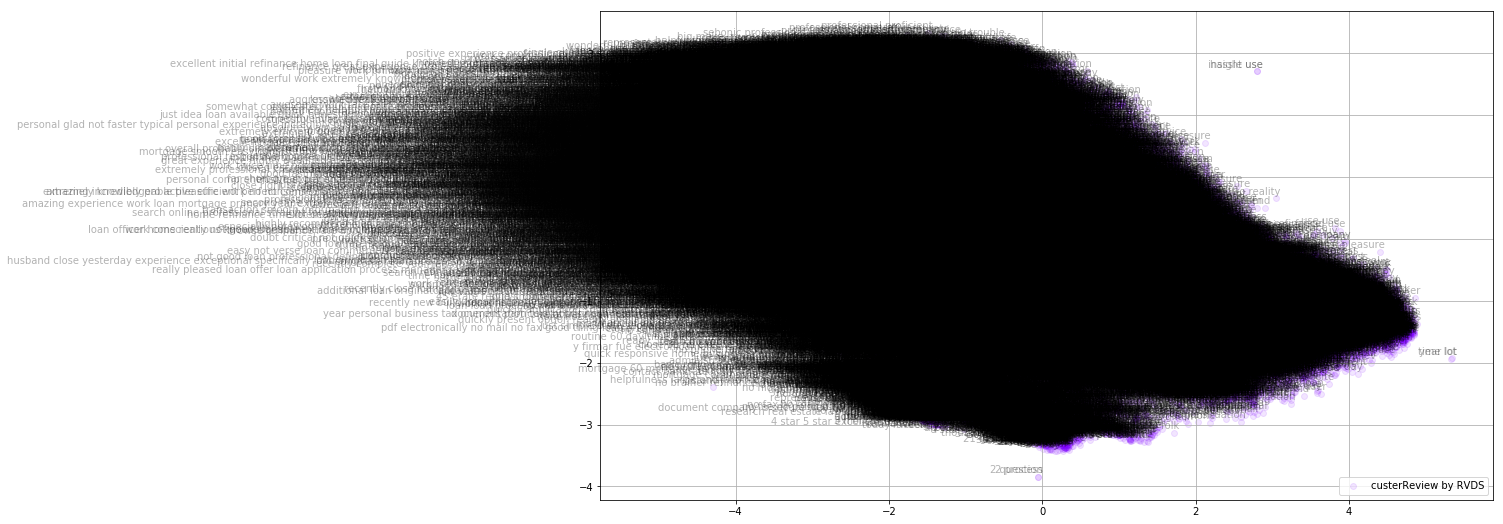

In [16]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# % matplotlib inline

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(nouns_vec_df.values)


def tsne_plot_2d(label, embeddings, words=[], a=1):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, c=colors, alpha=a, label=label)
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.3, xy=(x[i], y[i]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.grid(True)
    plt.savefig("hhh.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()
    
# tsne_plot_2d('custerReview by RVDS', tsne_results, list(nouns_vec_df.index),a=0.1)

# Aspect-based mining

In [234]:
# sent_list = []
# for doc in nlp.pipe(cr_df.REVIEWTEXT.astype('unicode').values[:1000], batch_size=1000, n_threads=-1):
#     sent_list.extend(list(doc.sents))

# sent_list[:10]
nounchunks = []
for doc in nlp.pipe(cr_df.REVIEWTEXT.astype('unicode').values[:1000], batch_size=1000, n_threads=-1):
    nounchunks.extend(list(doc.noun_chunks))
#     nouns_vec_dict.update({tk.text:tk.vector for tk in doc.noun_chunks if len(tk.text.split())>1 and tk.has_vector})


In [285]:

Amod_Nsubj_toVec = {}
Nsubj_toVec = {}
for nouns in list(set(nounchunks)):
    for token in nouns:
        if token.dep_ =='amod'and token.head.dep_!='nsubj':
            key = " ".join([token.lemma_, token.head.lemma_])
            if key not in Amod_Nsubj_toVec.keys():
                Amod_Nsubj_toVec[key] = token.vector +  token.head.vector
            
            Nsubj.append(token.head.lemma_)
            if token.head.lemma_ not in Nsubj_toVec.keys():
                Nsubj_toVec[token.head.lemma_] = token.head.vector
                
from collections import Counter
cnt = Counter(Nsubj)
cnt.most_common(30)

[('rate', 478),
 ('experience', 298),
 ('process', 226),
 ('time', 191),
 ('service', 130),
 ('company', 104),
 ('loan', 98),
 ('lender', 90),
 ('job', 86),
 ('home', 86),
 ('mortgage', 70),
 ('cost', 54),
 ('document', 54),
 ('review', 52),
 ('option', 48),
 ('bank', 48),
 ('question', 44),
 ('response', 42),
 ('refinance', 42),
 ('purchase', 40),
 ('deal', 40),
 ('contact', 36),
 ('people', 34),
 ('transaction', 34),
 ('officer', 34),
 ('manner', 34),
 ('communication', 34),
 ('information', 32),
 ('thing', 30),
 ('refi', 28)]

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 417 samples in 0.000s...
[t-SNE] Computed neighbors for 417 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 417 / 417
[t-SNE] Mean sigma: 0.167287
[t-SNE] KL divergence after 250 iterations with early exaggeration: 290.636871
[t-SNE] KL divergence after 1000 iterations: 0.909284


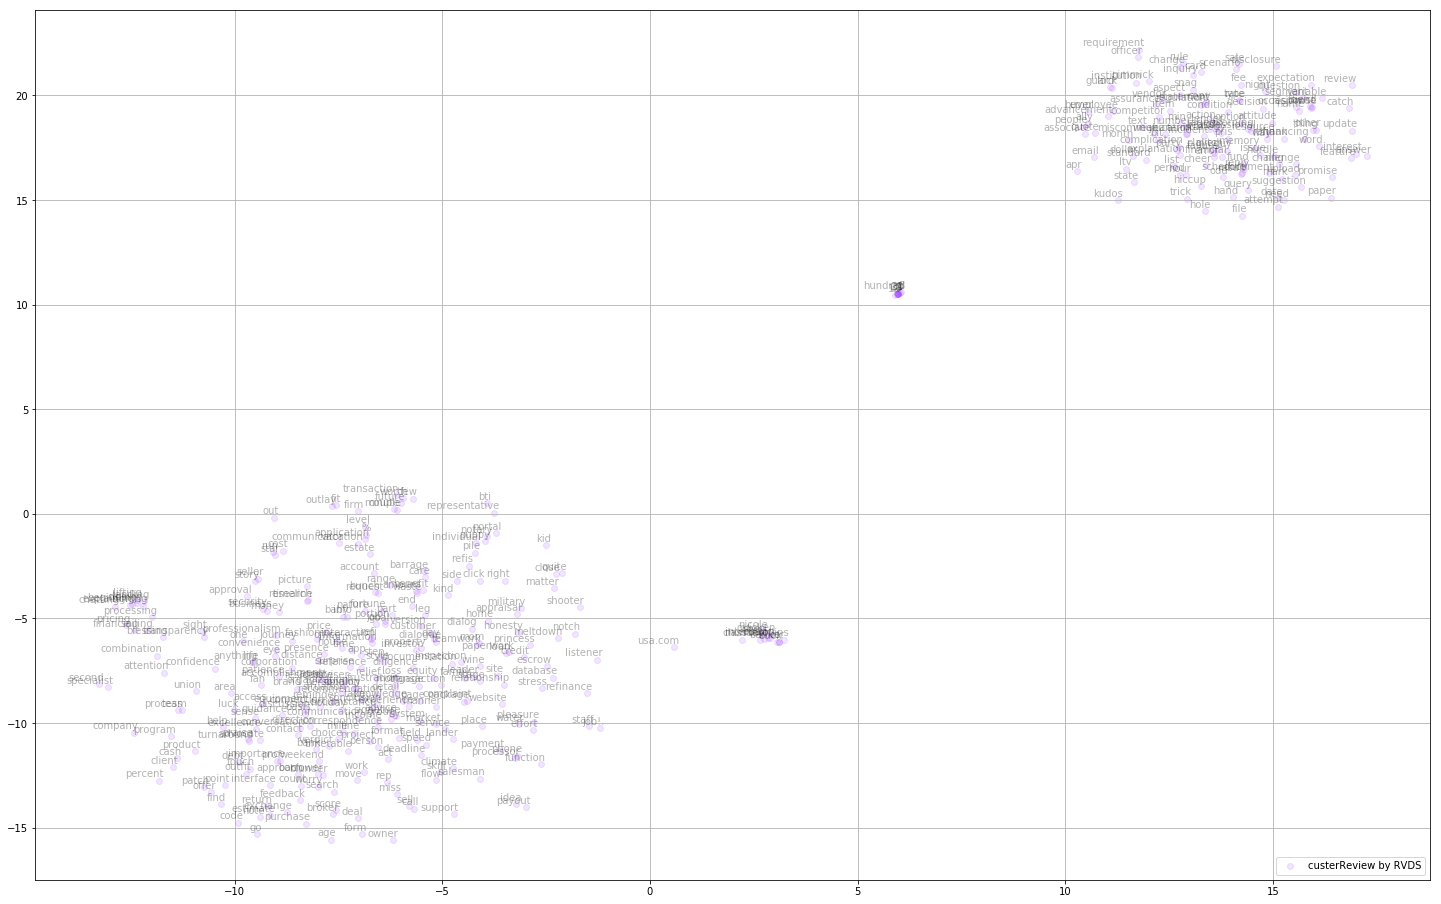

In [286]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# % matplotlib inline

tsne = TSNE(n_components=2, metric = 'cosine', early_exaggeration=40, learning_rate = 300, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(list(Nsubj_toVec.values()))


def tsne_plot_2d(label, embeddings, words=[], a=1):
    plt.figure(figsize=(25, 16))
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, c=colors, alpha=a, label=label)
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.3, xy=(x[i], y[i]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.grid(True)
    plt.savefig("hhh.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()
    
tsne_plot_2d('custerReview by RVDS', tsne_results, list(Nsubj_toVec.keys()),a=0.1)



[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 417 samples in 0.000s...
[t-SNE] Computed neighbors for 417 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 417 / 417
[t-SNE] Mean sigma: 0.167287
[t-SNE] KL divergence after 250 iterations with early exaggeration: 131.031631
[t-SNE] KL divergence after 300 iterations: 4.369047


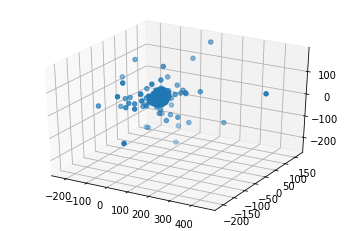

In [288]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

tsne3d = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300, metric='cosine')
tsne3d_results = tsne3d.fit_transform(list(Nsubj_toVec.values()))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*zip(*tsne3d_results))
plt.show()